# Preparing Environment
* We'll prepare our environment in this section, we'll import libraries and the data we'll use.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import time
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.compat.v1.keras.layers import CuDNNGRU
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.callbacks as callbacks
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import warnings as wrn
wrn.filterwarnings('ignore')

import os

In [ ]:
! gdown --id 1Fc_ZnsIYbY8JIUYl57fqeYRawhL9YJeA #train.csv

tf.random.set_seed(2021)
train_set = pd.read_csv("train.csv")

Downloading...
From: https://drive.google.com/uc?id=1Fc_ZnsIYbY8JIUYl57fqeYRawhL9YJeA
To: /content/train.csv
100% 14.0M/14.0M [00:00<00:00, 124MB/s]


In [ ]:
train_set.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


### Step 1: Cleaning and Extracting The Required Data
Extracting the useful rows for training the model.  The actual user review and the recommended or not recommended indicator.

In [ ]:
x = train_set["user_review"]
y = train_set["user_suggestion"]

In [ ]:
def cleanTexts(texts):
    cleaned = []
    pattern = "[^a-zA-Z0-9]"
    for text in texts:
        clrd = re.sub(pattern," ",text).lower().strip()
        cleaned.append(clrd)
    return cleaned

In [ ]:
x_cleaned = cleanTexts(x)

### Step 2: Tokenizing and Padding Data

In [ ]:
tokenizer = Tokenizer(num_words=6500)
tokenizer.fit_on_texts(x_cleaned)
x_tokens = tokenizer.texts_to_sequences(x_cleaned)

In [ ]:
len_arr = [len(s) for s in x_tokens]
MAX_LEN = int(np.percentile(len_arr,.8))

In [ ]:
print(MAX_LEN)

15


In [ ]:
x_tokens_pad = pad_sequences(x_tokens,maxlen=MAX_LEN)

### Step 3: Train Test Splitting
In this section we'll split our set into train and test. The random_state is used for reproducibility.

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x_tokens_pad,np.asarray(y),test_size=0.1,random_state=42)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(15744, 15)
(1750, 15)
(15744,)
(1750,)


# Function definition to vary parameters in model build

In [ ]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
# We've added 1 because of padding

# Each world will be 50D vector.
VECTOR_SIZE = 50
def buildModel_varyparams(MAX_LEN,dropoutval,activation_func,learningrate,num_neurons1,num_neurons2):
    
    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=VOCAB_SIZE,
                                output_dim=VECTOR_SIZE,
                                input_length=MAX_LEN
                              ))
    model.add(layers.Dropout(dropoutval))
    model.add(layers.LSTM(num_neurons1, return_sequences=True)) #was 256
    model.add(layers.LSTM(num_neurons2, return_sequences=True)) #was 512
    model.add(layers.LSTM(num_neurons2, return_sequences=True)) #was 512
    model.add(layers.LSTM(num_neurons2, return_sequences=False)) #was 512
    model.add(layers.Dense(1,activation=activation_func)) #was sigmoid
    
    opt = keras.optimizers.Adam(learning_rate=learningrate) #was 0.001
    model.compile(optimizer=opt,loss="binary_crossentropy",metrics=["accuracy"])
    return model


Creating the parameter grid to be used in Grid and Randomized Search.

Due to the issues mentioned in the report these sections are commented out but kept to show the intended work

In [ ]:
# param_grid = {
#     'dropoutval': [0.6, 0.7, 0.8, 0.9],
#     'activation_func': ["sigmoid", "relu"],
#     'learningrate': [0.1, 0.01, 0.001],
#     'neurons1': [64, 128, 256, 512]
# }

Executing the Model creation and Randomized Search (Grid Search before changes) 

In [ ]:
# model = KerasClassifier(build_fn = buildModel_varyparams, epochs=15, verbose=0)
# random = RandomizedSearchCV(model, param_grid, n_iter = 30, n_jobs=-1, cv=3)
# random_result = random.fit(x_train, y_train)

Outputting the Results of the Randomized Search in a readable layout

In [ ]:
# print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
# means = random_result.cv_results_['mean_test_score']
# stds = random_result.cv_results_['std_test_score']
# params = random_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

#Neuron Count Layer 1
Vary the number of neurons in the first LSTM layer

In [ ]:
val=0
num_neurons1 = [32,64,128,256,512]
final_val_losses = []
final_val_accs = []

for i in range(0,5):
    print(i)
    model = buildModel_varyparams(MAX_LEN,dropoutval=val,activation_func="sigmoid",learningrate=0.001,num_neurons1=num_neurons1[i], num_neurons2=512)
    history = model.fit(x_train,y_train,epochs=15,validation_split=0.3) 
    final_val_losses.append(history.history['val_loss'][14])
    final_val_accs.append(history.history['val_accuracy'][14])

0
Epoch 1/15
345/345 [==============================] - 29s 49ms/step - loss: 0.5995 - accuracy: 0.6709 - val_loss: 0.5384 - val_accuracy: 0.7254
Epoch 2/15
345/345 [==============================] - 15s 43ms/step - loss: 0.4488 - accuracy: 0.7907 - val_loss: 0.5487 - val_accuracy: 0.7278
Epoch 3/15
345/345 [==============================] - 15s 43ms/step - loss: 0.3694 - accuracy: 0.8336 - val_loss: 0.6665 - val_accuracy: 0.7254
Epoch 4/15
345/345 [==============================] - 15s 43ms/step - loss: 0.2910 - accuracy: 0.8781 - val_loss: 0.6441 - val_accuracy: 0.7191
Epoch 5/15
345/345 [==============================] - 15s 43ms/step - loss: 0.2192 - accuracy: 0.9114 - val_loss: 0.8058 - val_accuracy: 0.7011
Epoch 6/15
345/345 [==============================] - 15s 43ms/step - loss: 0.1635 - accuracy: 0.9338 - val_loss: 0.9554 - val_accuracy: 0.7007
Epoch 7/15
345/345 [==============================] - 15s 43ms/step - loss: 0.1241 - accuracy: 0.9509 - val_loss: 1.2193 - val_accurac

#Neuron Count Layer 1 Plots

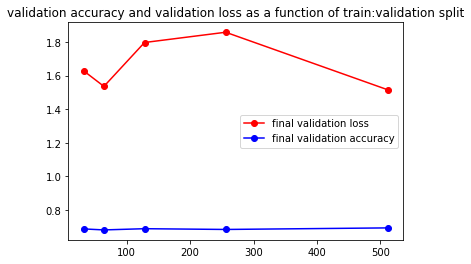

512


In [ ]:
plt.plot(num_neurons1,final_val_losses,'ro-',label="final validation loss")
plt.plot(num_neurons1,final_val_accs,'bo-',label='final validation accuracy')
plt.title("validation accuracy and validation loss as a function of Number of neurons in first LSTM layer")
plt.legend()
plt.show()

bestnumneurons1 = num_neurons1[int(np.where(final_val_losses==np.min(final_val_losses))[0])]
print(bestnumneurons1)

#Neuron Count Remaining Layers
Varying the number of Neurons in the three remaining LSTM layers

In [ ]:
val = 0
num_neurons2 = [32,64,128,256,512]
final_val_losses = []
final_val_accs = []

for i in range(0,5):
    print(i)
    model = buildModel_varyparams(MAX_LEN,dropoutval=val,activation_func="sigmoid",learningrate=0.001,num_neurons1=bestnumneurons1, num_neurons2=num_neurons2[i])
    history = model.fit(x_train,y_train,epochs=15,validation_split=0.3) 
    final_val_losses.append(history.history['val_loss'][14])
    final_val_accs.append(history.history['val_accuracy'][14])

0
Epoch 1/15
345/345 [==============================] - 22s 44ms/step - loss: 0.6067 - accuracy: 0.6621 - val_loss: 0.5435 - val_accuracy: 0.7218
Epoch 2/15
345/345 [==============================] - 13s 39ms/step - loss: 0.4608 - accuracy: 0.7809 - val_loss: 0.5490 - val_accuracy: 0.7269
Epoch 3/15
345/345 [==============================] - 13s 39ms/step - loss: 0.3899 - accuracy: 0.8260 - val_loss: 0.6069 - val_accuracy: 0.7248
Epoch 4/15
345/345 [==============================] - 13s 39ms/step - loss: 0.3213 - accuracy: 0.8630 - val_loss: 0.5843 - val_accuracy: 0.7225
Epoch 5/15
345/345 [==============================] - 13s 39ms/step - loss: 0.2548 - accuracy: 0.8999 - val_loss: 0.7292 - val_accuracy: 0.7051
Epoch 6/15
345/345 [==============================] - 13s 39ms/step - loss: 0.1908 - accuracy: 0.9268 - val_loss: 0.8282 - val_accuracy: 0.7047
Epoch 7/15
345/345 [==============================] - 14s 39ms/step - loss: 0.1416 - accuracy: 0.9478 - val_loss: 1.0484 - val_accurac

#Neuron Count Remaining Layers Plots

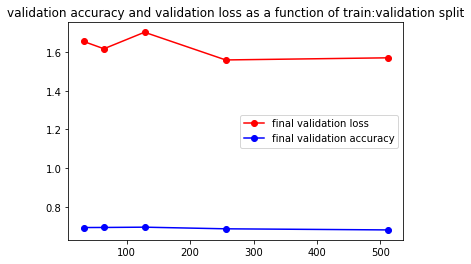

256


In [ ]:
plt.plot(num_neurons2,final_val_losses,'ro-',label="final validation loss")
plt.plot(num_neurons2,final_val_accs,'bo-',label='final validation accuracy')
plt.title("validation accuracy and validation loss as a function of Number of neurons in subsequent LSTM layers")
plt.legend()
plt.show()

bestnumneurons2 = num_neurons1[int(np.where(final_val_losses==np.min(final_val_losses))[0])]
print(bestnumneurons2)

#Train:Validation Split
Testing for the best Train:Validation split in the data

In [ ]:
val = 0
splits = []
final_val_losses = []
final_val_accs = []

for i in range(1,6):
    val = i*0.1
    print(i)
    splits.append(val)
    model = buildModel_varyparams(MAX_LEN,dropoutval=val,activation_func="sigmoid",learningrate=0.001,num_neurons1=bestnumneurons1, num_neurons2=bestnumneurons2)
    history = model.fit(x_train,y_train,epochs=15,validation_split=val) 
    final_val_losses.append(history.history['val_loss'][14])
    final_val_accs.append(history.history['val_accuracy'][14])

1
Epoch 1/15
443/443 [==============================] - 25s 40ms/step - loss: 0.5894 - accuracy: 0.6789 - val_loss: 0.5314 - val_accuracy: 0.7302
Epoch 2/15
443/443 [==============================] - 15s 34ms/step - loss: 0.4624 - accuracy: 0.7848 - val_loss: 0.5277 - val_accuracy: 0.7314
Epoch 3/15
443/443 [==============================] - 15s 34ms/step - loss: 0.4019 - accuracy: 0.8215 - val_loss: 0.5410 - val_accuracy: 0.7397
Epoch 4/15
443/443 [==============================] - 15s 34ms/step - loss: 0.3403 - accuracy: 0.8603 - val_loss: 0.5638 - val_accuracy: 0.7244
Epoch 5/15
443/443 [==============================] - 15s 34ms/step - loss: 0.2798 - accuracy: 0.8878 - val_loss: 0.6854 - val_accuracy: 0.7162
Epoch 6/15
443/443 [==============================] - 15s 34ms/step - loss: 0.2257 - accuracy: 0.9092 - val_loss: 0.7642 - val_accuracy: 0.7098
Epoch 7/15
443/443 [==============================] - 15s 34ms/step - loss: 0.1735 - accuracy: 0.9366 - val_loss: 0.8484 - val_accurac

# Train:Validation Split Plots

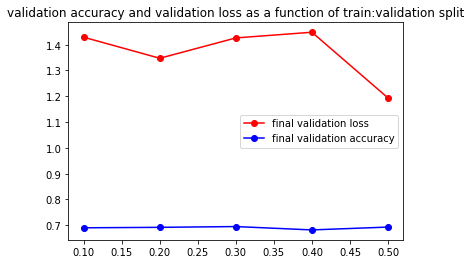

0.5


In [ ]:
plt.plot(splits,final_val_losses,'ro-',label="final validation loss")
plt.plot(splits,final_val_accs,'bo-',label='final validation accuracy')
plt.title("validation accuracy and validation loss as a function of train:validation split")
plt.legend()
plt.show()

bestsplit = splits[int(np.where(final_val_losses==np.min(final_val_losses))[0])]
print(bestsplit)

# Varying Dropout

In [ ]:
val = 0
vals = []
final_val_losses = []
final_val_accs = []

for i in range(0,10):
    val+=0.1
    print(i)
    vals.append(val)
    model = buildModel_varyparams(MAX_LEN,dropoutval=val,activation_func="sigmoid",learningrate=0.001,num_neurons1=bestnumneurons1, num_neurons2=bestnumneurons2)
    history = model.fit(x_train,y_train,epochs=15,validation_split=bestsplit) 
    final_val_losses.append(history.history['val_loss'][14])
    final_val_accs.append(history.history['val_accuracy'][14])

0
Epoch 1/15
246/246 [==============================] - 22s 65ms/step - loss: 0.6247 - accuracy: 0.6500 - val_loss: 0.5484 - val_accuracy: 0.7129
Epoch 2/15
246/246 [==============================] - 11s 44ms/step - loss: 0.4673 - accuracy: 0.7839 - val_loss: 0.5430 - val_accuracy: 0.7309
Epoch 3/15
246/246 [==============================] - 11s 44ms/step - loss: 0.3784 - accuracy: 0.8356 - val_loss: 0.5986 - val_accuracy: 0.7237
Epoch 4/15
246/246 [==============================] - 11s 45ms/step - loss: 0.3055 - accuracy: 0.8746 - val_loss: 0.6501 - val_accuracy: 0.7147
Epoch 5/15
246/246 [==============================] - 11s 44ms/step - loss: 0.2421 - accuracy: 0.9068 - val_loss: 0.8180 - val_accuracy: 0.7127
Epoch 6/15
246/246 [==============================] - 11s 45ms/step - loss: 0.1863 - accuracy: 0.9313 - val_loss: 0.8605 - val_accuracy: 0.7031
Epoch 7/15
246/246 [==============================] - 11s 45ms/step - loss: 0.1438 - accuracy: 0.9470 - val_loss: 1.1784 - val_accurac

# Varying Dropout Plots

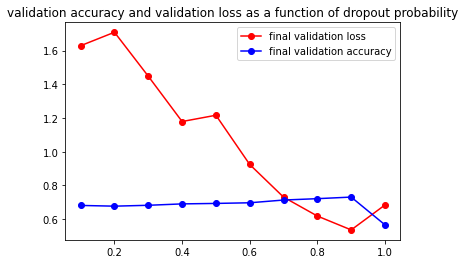

0.8999999999999999


In [ ]:
plt.plot(vals,final_val_losses,'ro-',label="final validation loss")
plt.plot(vals,final_val_accs,'bo-',label='final validation accuracy')
plt.title("validation accuracy and validation loss as a function of dropout probability")
plt.legend()
plt.show()

bestdropout = vals[int(np.where(final_val_losses==np.min(final_val_losses))[0])]
print(bestdropout)

# Varying Activation Function
Testing the sigmoid versus relu activation functions

In [ ]:
model = buildModel_varyparams(MAX_LEN,dropoutval=bestdropout,activation_func="sigmoid",learningrate=0.001,num_neurons1=bestnumneurons1, num_neurons2=bestnumneurons2)
history = model.fit(x_train,y_train,epochs=15,validation_split=bestsplit)
sigmoid_loss = history.history['val_loss']
sigmoid_acc = history.history['val_accuracy']

model = buildModel_varyparams(MAX_LEN,dropoutval=bestdropout,activation_func="relu",learningrate=0.001,num_neurons1=bestnumneurons1, num_neurons2=bestnumneurons2)
history = model.fit(x_train,y_train,epochs=15,validation_split=bestsplit)
relu_loss = history.history['val_loss']
relu_acc = history.history['val_accuracy']

Epoch 1/15
246/246 [==============================] - 24s 71ms/step - loss: 0.6851 - accuracy: 0.5701 - val_loss: 0.6831 - val_accuracy: 0.5662
Epoch 2/15
246/246 [==============================] - 11s 44ms/step - loss: 0.6459 - accuracy: 0.6237 - val_loss: 0.5980 - val_accuracy: 0.6804
Epoch 3/15
246/246 [==============================] - 11s 45ms/step - loss: 0.5826 - accuracy: 0.6944 - val_loss: 0.5548 - val_accuracy: 0.7163
Epoch 4/15
246/246 [==============================] - 11s 44ms/step - loss: 0.5505 - accuracy: 0.7218 - val_loss: 0.5521 - val_accuracy: 0.7227
Epoch 5/15
246/246 [==============================] - 11s 44ms/step - loss: 0.5214 - accuracy: 0.7504 - val_loss: 0.5502 - val_accuracy: 0.7255
Epoch 6/15
246/246 [==============================] - 11s 44ms/step - loss: 0.5068 - accuracy: 0.7489 - val_loss: 0.5393 - val_accuracy: 0.7309
Epoch 7/15
246/246 [==============================] - 11s 45ms/step - loss: 0.4837 - accuracy: 0.7712 - val_loss: 0.5460 - val_accuracy:

# Varying Activation Function Plots

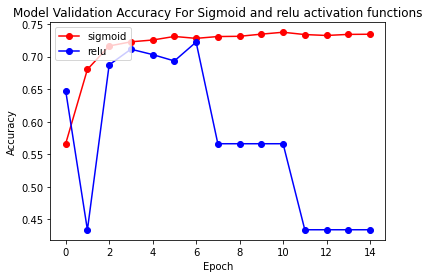

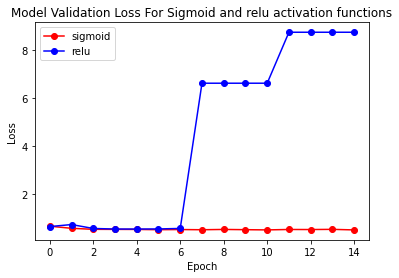

sigmoid


In [ ]:
epochs = np.linspace(0,14,15)
plt.plot(epochs,sigmoid_acc,'ro-')
plt.plot(epochs,relu_acc,'bo-')
plt.title('Model Validation Accuracy For Sigmoid and relu activation functions')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['sigmoid', 'relu'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(epochs,sigmoid_loss,'ro-')
plt.plot(epochs,relu_loss,'bo-')
plt.title('Model Validation Loss For Sigmoid and relu activation functions')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['sigmoid', 'relu'], loc='upper left')
plt.show()

best_activation = ""
if (sigmoid_loss[14]>relu_loss[14]):
  best_activation = "relu"
else:
  best_activation = "sigmoid"
  
print(best_activation)

#Varying Learning Rate 

In [ ]:
val = 0
rates = []
final_val_losses = []
final_val_accs = []

for i in range(1,7):
    val = 1*(10**(-i))
    print(i)
    rates.append(val)
    model = buildModel_varyparams(MAX_LEN,dropoutval=bestdropout,activation_func=best_activation,learningrate=val,num_neurons1=bestnumneurons1, num_neurons2=bestnumneurons2)
    history = model.fit(x_train,y_train,epochs=15,validation_split=bestsplit) 
    final_val_losses.append(history.history['val_loss'][14])
    final_val_accs.append(history.history['val_accuracy'][14])

1
Epoch 1/15
246/246 [==============================] - 24s 73ms/step - loss: 0.8413 - accuracy: 0.5117 - val_loss: 0.6982 - val_accuracy: 0.5636
Epoch 2/15
246/246 [==============================] - 11s 45ms/step - loss: 0.8183 - accuracy: 0.5306 - val_loss: 0.9264 - val_accuracy: 0.5141
Epoch 3/15
246/246 [==============================] - 11s 44ms/step - loss: 1.0182 - accuracy: 0.5147 - val_loss: 1.0342 - val_accuracy: 0.5370
Epoch 4/15
246/246 [==============================] - 11s 45ms/step - loss: 0.9660 - accuracy: 0.5260 - val_loss: 1.0491 - val_accuracy: 0.4898
Epoch 5/15
246/246 [==============================] - 11s 44ms/step - loss: 0.9958 - accuracy: 0.5107 - val_loss: 1.0571 - val_accuracy: 0.5287
Epoch 6/15
246/246 [==============================] - 11s 45ms/step - loss: 0.9810 - accuracy: 0.5135 - val_loss: 0.9654 - val_accuracy: 0.5262
Epoch 7/15
246/246 [==============================] - 11s 45ms/step - loss: 0.9985 - accuracy: 0.5137 - val_loss: 1.0144 - val_accurac

# Varying Learning Rate Plots

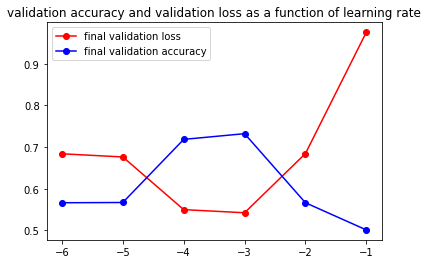

0.001


In [ ]:
plt.plot(np.log10(np.array(rates)),final_val_losses,'ro-',label="final validation loss")
plt.plot(np.log10(np.array(rates)),final_val_accs,'bo-',label='final validation accuracy')
plt.title("validation accuracy and validation loss as a function of learning rate")
plt.legend()
plt.show()

bestrate = rates[int(np.where(final_val_losses==np.min(final_val_losses))[0])]

print(bestrate)

# Final Model behaviour


Epoch 1/15
246/246 [==============================] - 24s 72ms/step - loss: 0.6843 - accuracy: 0.5713 - val_loss: 0.6826 - val_accuracy: 0.5664
Epoch 2/15
246/246 [==============================] - 11s 44ms/step - loss: 0.6425 - accuracy: 0.6230 - val_loss: 0.5752 - val_accuracy: 0.6966
Epoch 3/15
246/246 [==============================] - 11s 44ms/step - loss: 0.5794 - accuracy: 0.6960 - val_loss: 0.5615 - val_accuracy: 0.7050
Epoch 4/15
246/246 [==============================] - 11s 45ms/step - loss: 0.5408 - accuracy: 0.7259 - val_loss: 0.5542 - val_accuracy: 0.7242
Epoch 5/15
246/246 [==============================] - 11s 45ms/step - loss: 0.5180 - accuracy: 0.7487 - val_loss: 0.5484 - val_accuracy: 0.7262
Epoch 6/15
246/246 [==============================] - 11s 44ms/step - loss: 0.5002 - accuracy: 0.7585 - val_loss: 0.5374 - val_accuracy: 0.7334
Epoch 7/15
246/246 [==============================] - 11s 45ms/step - loss: 0.4814 - accuracy: 0.7716 - val_loss: 0.5404 - val_accuracy:

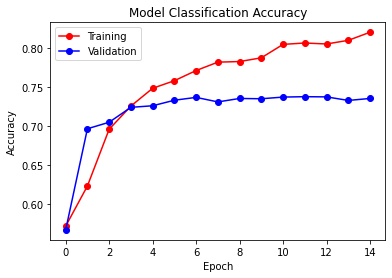

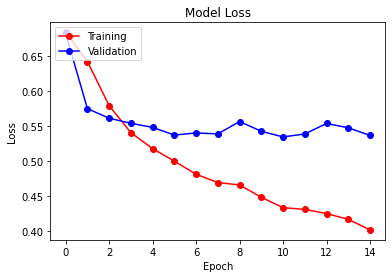

In [ ]:
model = buildModel_varyparams(MAX_LEN,dropoutval=bestdropout,activation_func=best_activation,learningrate=bestrate,num_neurons1=bestnumneurons1, num_neurons2=bestnumneurons2)
history = model.fit(x_train,y_train,epochs=15,validation_split=bestsplit) 

plt.plot(history.history['accuracy'],'ro-')
plt.plot(history.history['val_accuracy'],'bo-')
plt.title('Model Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'],'ro-')
plt.plot(history.history['val_loss'],'bo-')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# Final Test
Testing the optimized model using the test set

Epoch 1/15
246/246 [==============================] - 21s 61ms/step - loss: 0.6845 - accuracy: 0.5716 - val_loss: 0.6590 - val_accuracy: 0.6228
Epoch 2/15
246/246 [==============================] - 11s 44ms/step - loss: 0.6311 - accuracy: 0.6380 - val_loss: 0.5790 - val_accuracy: 0.6904
Epoch 3/15
246/246 [==============================] - 11s 44ms/step - loss: 0.5680 - accuracy: 0.7111 - val_loss: 0.5560 - val_accuracy: 0.7127
Epoch 4/15
246/246 [==============================] - 11s 44ms/step - loss: 0.5377 - accuracy: 0.7313 - val_loss: 0.5513 - val_accuracy: 0.7294
Epoch 5/15
246/246 [==============================] - 11s 43ms/step - loss: 0.5137 - accuracy: 0.7510 - val_loss: 0.5339 - val_accuracy: 0.7307
Epoch 6/15
246/246 [==============================] - 11s 44ms/step - loss: 0.4937 - accuracy: 0.7651 - val_loss: 0.5513 - val_accuracy: 0.7327
Epoch 7/15
246/246 [==============================] - 11s 44ms/step - loss: 0.4820 - accuracy: 0.7685 - val_loss: 0.5597 - val_accuracy:

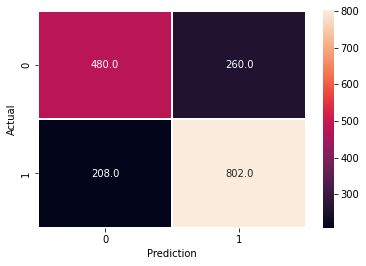

In [ ]:
#y_pred = model.predict_classes(x_test) # yash: changed from predict_classes to the line below this comment
model = buildModel_varyparams(MAX_LEN,dropoutval=bestdropout,activation_func=best_activation,learningrate=bestrate,num_neurons1=bestnumneurons1, num_neurons2=bestnumneurons2)
history = model.fit(x_train,y_train,epochs=15,validation_split=bestsplit) 

predictions=model.predict(x_test)

for i in range(0,len(predictions)):
  if predictions[i]>0.5:

      predictions[i]=1
  else:
    predictions[i]=0
y_pred= predictions
print(y_pred)

accuracy_sc = round(accuracy_score(y_pred=y_pred,y_true=y_test)*100,2)
conf_matrix = confusion_matrix(y_pred=y_pred,y_true=y_test)


print("Accuracy score is {}% ".format(accuracy_sc))

plt.subplots()
sns.heatmap(conf_matrix,annot=True,linewidths=1.5,fmt=".1f")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()